Import modules

In [1]:
%matplotlib inline
import os
from os.path import join, exists, expandvars
import pandas as pd
from IPython.display import display, Markdown
import seaborn
#import seaborn.xkcd_rgb as colors
from tax_credit.plotting_functions import (pointplot_from_data_frame,
                                           boxplot_from_data_frame,
                                           heatmap_from_data_frame,
                                           per_level_kruskal_wallis,
                                           beta_diversity_pcoa,
                                           average_distance_boxplots,
                                           rank_optimized_method_performance_by_dataset)
from tax_credit.eval_framework import (evaluate_results,
                                       method_by_dataset_a1,
                                       parameter_comparisons,
                                       merge_expected_and_observed_tables,
                                       filter_df)

Configure local environment-specific values

In [2]:
## project_dir should be the directory where you've downloaded (or cloned) the 
## tax-credit-data repository. 
project_dir = expandvars('$HOME/tax-credit-data/')

## expected_results_dir contains expected composition data in the structure
## expected_results_dir/<dataset name>/<reference name>/expected/
expected_results_dir = join(project_dir, "data/precomputed-results/", "mock-community")

## mock_results_fp designates the files to which summary results are written.
## If this file exists, it can be read in to generate results plots, instead
## of computing new scores.
mock_results_fp = join(expected_results_dir, 'mock_results.tsv')

## results_dirs should contain the directory or directories where
## results can be found. By default, this is the same location as expected 
## results included with the project. If other results should be included, 
## absolute paths to those directories should be added to this list.
results_dirs = [expected_results_dir]

## directory containing mock community data, e.g., feature table without taxonomy
mock_dir = join(project_dir, "data", "mock-community")

## Minimum number of times an OTU must be observed for it to be included in analyses. Edit this
## to analyze the effect of the minimum count on taxonomic results.
min_count = 1

## Define the range of taxonomic levels over which to compute accuracy scores.
## The default given below will compute order (level 2) through species (level 6)
taxonomy_level_range = range(2,7)


# we can save plots in this directory
outdir = join(project_dir, "plots")
if not os.path.exists(outdir):
    os.makedirs(outdir)

In [3]:
project_dir

'/home/mosele/tax-credit-data/'

In [4]:
#dataset_ids = ['mock-3']
dataset_ids = ['mock-1', 'mock-2', 'mock-3', 'mock-4', 'mock-5','mock-6', 'mock-7', 'mock-8','mock-12','mock-13',
               'mock-14', 'mock-15', 'mock-16','mock-18', 'mock-19', 'mock-20', 'mock-21', 'mock-22']
method_ids = ['q2-NB', 'q2-SFM-RF', 'q2-SFM-SDG','q2-SFM-NB']
ref_ids = ['gg_13_8_otus']

Find mock community pre-computed tables, expected tables, and "query" tables

Note: if you have added additional methods to add, set append=True. If you are attempting to recompute pre-computed results, set force=True.

This cell will take a few minutes to run if new results are being added, so hold onto your hat. If you are attempting to re-compute everything, it may take an hour or so, so go take a nap.

In [5]:
mock_results = evaluate_results(results_dirs, 
                                expected_results_dir, 
                                mock_results_fp, 
                                mock_dir,
                                taxonomy_level_range=range(2,7), 
                                min_count=min_count,
                                taxa_to_keep=None, 
                                md_key='taxonomy', 
                                subsample=False,
                                per_seq_precision=True,
                                exclude=['other'],
                                dataset_ids=dataset_ids,
                                reference_ids=ref_ids,
                                method_ids=method_ids,
                                append=False,
                                force=True, #force=True the first time 
                                backup=False)

/home/mosele/tax-credit-data/data/precomputed-results/mock-community/mock_results.tsv already exists.
Reading in pre-computed evaluation results.
To overwrite, set force=True
Results have been filtered to only include datasets or reference databases or methods or parameters that are explicitly set by results params. To disable this function and load all results, set dataset_ids and reference_ids and method_ids and parameter_ids to None.


Compute and summarize precision, recall, and F-measure for mock communities

In [6]:
color_palette={ 
    'q2-NB':'black',
    'q2-SFM-RF':'darkgreen',
    'q2-SFM-SDG':'green',
    'q2-SFM-NB':'lime',
    }

y_vars = ["Precision", "Recall", "F-measure", "Taxon Accuracy Rate", "Taxon Detection Rate"]

/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


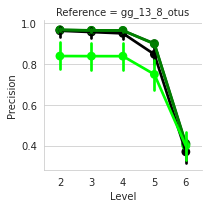

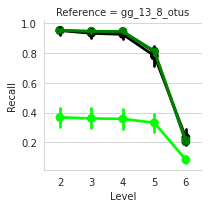

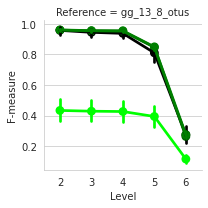

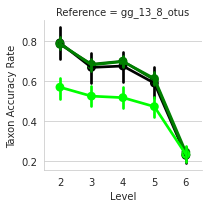

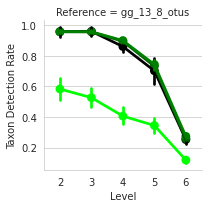

In [7]:
point = pointplot_from_data_frame(mock_results, "Level", y_vars, 
                                  group_by="Reference", color_by="Method",
                                  color_palette=color_palette)

In [8]:
for k, v in point.items():
    v.savefig(join(outdir, 'mock-{0}-lineplots.pdf'.format(k)))

Heatmaps show the performance of individual method/parameter combinations at each taxonomic level, in each reference database

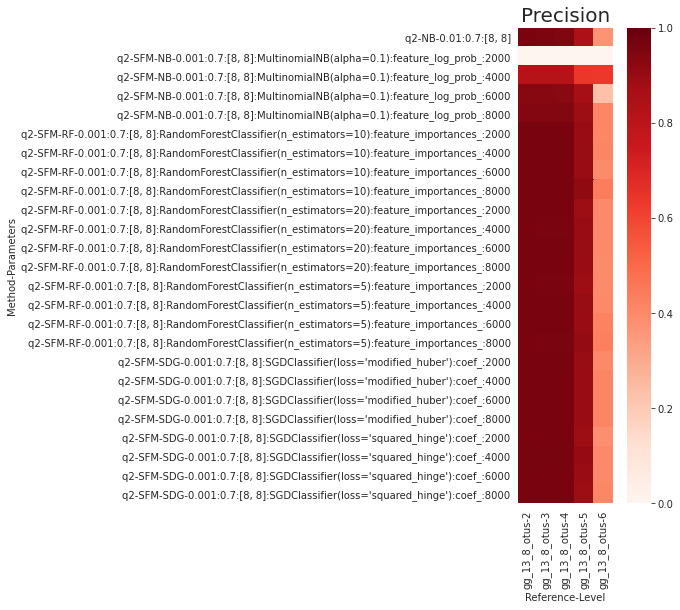

In [9]:
heatmap_from_data_frame(mock_results, metric="Precision", rows=["Method", "Parameters"], cols=["Reference", "Level"])

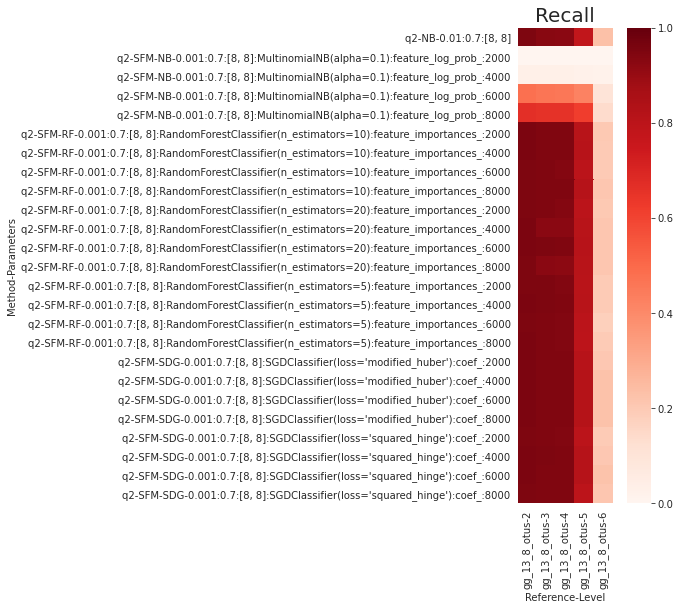

In [10]:
heatmap_from_data_frame(mock_results, metric="Recall", rows=["Method", "Parameters"], cols=["Reference", "Level"])

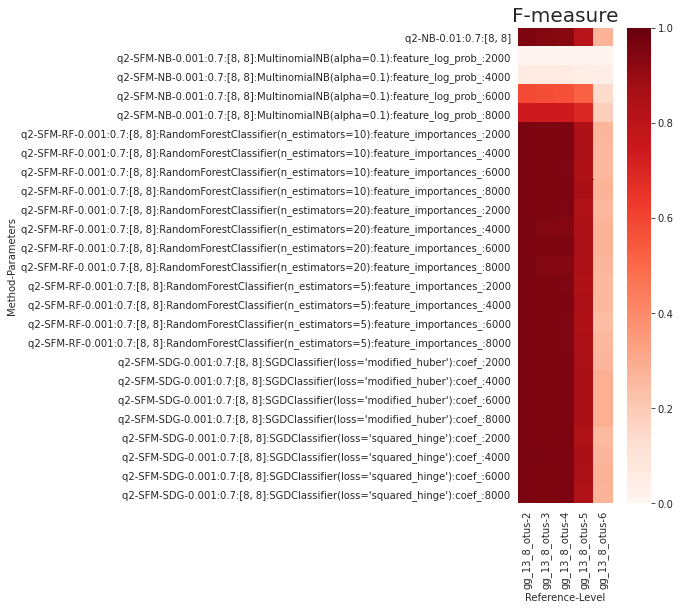

In [11]:
heatmap_from_data_frame(mock_results, metric="F-measure", rows=["Method", "Parameters"], cols=["Reference", "Level"])

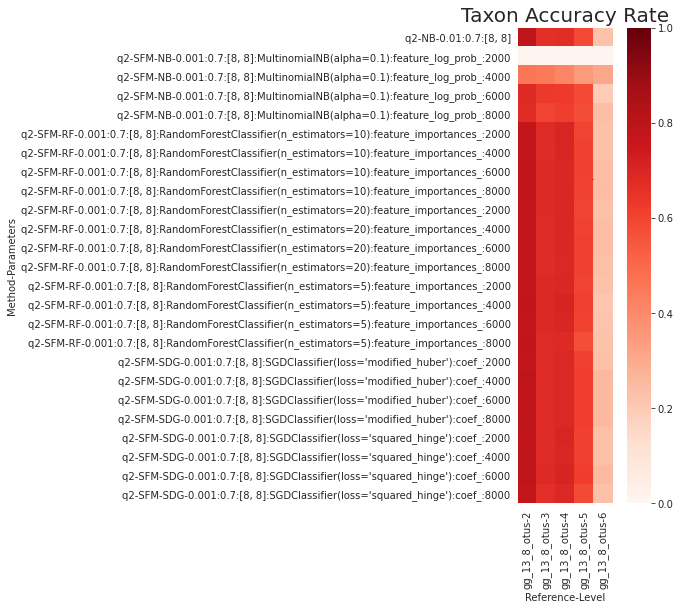

In [12]:
heatmap_from_data_frame(mock_results, metric="Taxon Accuracy Rate", rows=["Method", "Parameters"], cols=["Reference", "Level"])

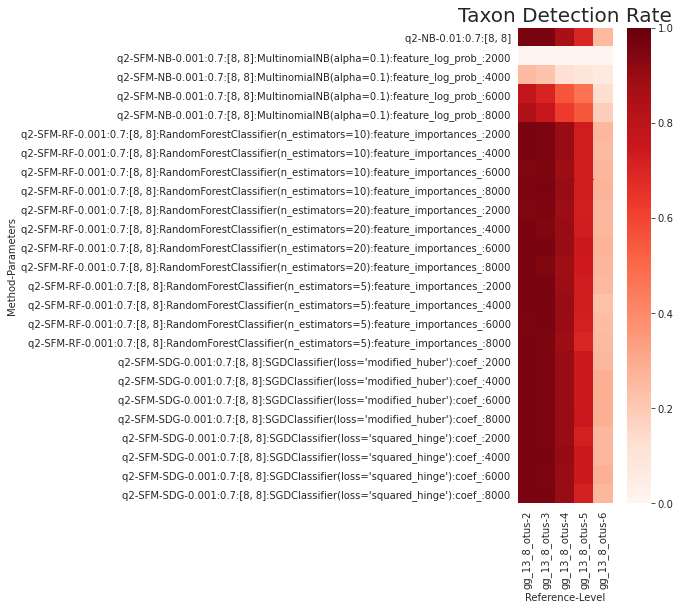

In [13]:
heatmap_from_data_frame(mock_results, metric="Taxon Detection Rate", rows=["Method", "Parameters"], cols=["Reference", "Level"])

now we will focus on results at species level (for genus level, change to level 5)

Method optimization

Which method/parameter configuration performed "best" for a given score? We can rank the top-performing configuration by dataset, method, and taxonomic level.

First, the top-performing method/configuration combination by dataset.

In [14]:
mock_results_6 = mock_results[mock_results['Level'] == 6]

pd.set_option('display.max_colwidth', None)
for dataset in mock_results_6['Dataset'].unique():
    display(Markdown('## {0}'.format(dataset)))
    best = method_by_dataset_a1(mock_results_6, dataset)
    display(best)

## mock-20

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate
544,q2-NB,"0.01:0.7:[8, 8]",0.347760,0.257116,0.295646,0.217391,0.263158
624,q2-SFM-SDG,"0.001:0.7:[8, 8]:SGDClassifier(loss='modified_huber'):coef_:6000",0.358282,0.237079,0.285344,0.200000,0.263158
559,q2-SFM-RF,"0.001:0.7:[8, 8]:RandomForestClassifier(n_estimators=5):feature_importances_:2000",0.353697,0.237079,0.283878,0.208333,0.263158
664,q2-SFM-NB,"0.001:0.7:[8, 8]:MultinomialNB(alpha=0.1):feature_log_prob_:4000",1.000000,0.119167,0.212956,0.500000,0.105263


## mock-3

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate
3423,q2-SFM-RF,"0.001:0.7:[8, 8]:RandomForestClassifier(n_estimators=5):feature_importances_:6000",0.692828,0.132625,0.222633,0.307692,0.20
3744,q2-SFM-SDG,"0.001:0.7:[8, 8]:SGDClassifier(loss='squared_hinge'):coef_:8000",0.471676,0.131325,0.205449,0.214286,0.15
3384,q2-NB,"0.01:0.7:[8, 8]",0.382944,0.127382,0.191173,0.214286,0.15
3824,q2-SFM-NB,"0.001:0.7:[8, 8]:MultinomialNB(alpha=0.1):feature_log_prob_:8000",0.496680,0.081928,0.140654,0.166667,0.10


## mock-2

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate
6629,q2-SFM-SDG,"0.001:0.7:[8, 8]:SGDClassifier(loss='modified_huber'):coef_:6000",0.728003,0.594806,0.654698,0.365854,0.405405
6589,q2-SFM-RF,"0.001:0.7:[8, 8]:RandomForestClassifier(n_estimators=10):feature_importances_:8000",0.752666,0.517804,0.613526,0.325581,0.378378
6549,q2-NB,"0.01:0.7:[8, 8]",0.548368,0.497371,0.521626,0.315789,0.324324
6659,q2-SFM-NB,"0.001:0.7:[8, 8]:MultinomialNB(alpha=0.1):feature_log_prob_:8000",0.682014,0.352422,0.464711,0.363636,0.324324


## mock-21

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate
7749,q2-NB,"0.01:0.7:[8, 8]",0.588483,0.337486,0.428967,0.181818,0.210526
7829,q2-SFM-SDG,"0.001:0.7:[8, 8]:SGDClassifier(loss='modified_huber'):coef_:6000",0.609409,0.328168,0.426607,0.181818,0.210526
7764,q2-SFM-RF,"0.001:0.7:[8, 8]:RandomForestClassifier(n_estimators=5):feature_importances_:2000",0.607757,0.328168,0.426202,0.181818,0.210526
7869,q2-SFM-NB,"0.001:0.7:[8, 8]:MultinomialNB(alpha=0.1):feature_log_prob_:4000",1.000000,0.003817,0.007605,0.333333,0.052632


## mock-18

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate
9014,q2-SFM-RF,"0.001:0.7:[8, 8]:RandomForestClassifier(n_estimators=5):feature_importances_:4000",0.693938,0.435689,0.535294,0.294118,0.333333
9039,q2-SFM-SDG,"0.001:0.7:[8, 8]:SGDClassifier(loss='modified_huber'):coef_:2000",0.594351,0.435689,0.502801,0.294118,0.333333
8954,q2-NB,"0.01:0.7:[8, 8]",0.477651,0.320670,0.383726,0.277778,0.333333
9069,q2-SFM-NB,"0.001:0.7:[8, 8]:MultinomialNB(alpha=0.1):feature_log_prob_:8000",0.557550,0.248758,0.344025,0.363636,0.266667


## mock-4

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate
11834,q2-SFM-RF,"0.001:0.7:[8, 8]:RandomForestClassifier(n_estimators=5):feature_importances_:6000",0.646259,0.137983,0.227411,0.230769,0.30
12154,q2-SFM-SDG,"0.001:0.7:[8, 8]:SGDClassifier(loss='squared_hinge'):coef_:8000",0.538091,0.137983,0.219643,0.230769,0.30
11794,q2-NB,"0.01:0.7:[8, 8]",0.408736,0.135428,0.203447,0.200000,0.25
12234,q2-SFM-NB,"0.001:0.7:[8, 8]:MultinomialNB(alpha=0.1):feature_log_prob_:8000",0.469844,0.083801,0.142233,0.190476,0.20


## mock-19

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate
15019,q2-SFM-RF,"0.001:0.7:[8, 8]:RandomForestClassifier(n_estimators=5):feature_importances_:4000",0.404059,0.264054,0.319387,0.25,0.333333
15044,q2-SFM-SDG,"0.001:0.7:[8, 8]:SGDClassifier(loss='modified_huber'):coef_:2000",0.369137,0.264054,0.307876,0.25,0.333333
14959,q2-NB,"0.01:0.7:[8, 8]",0.288889,0.199192,0.235798,0.25,0.333333
15064,q2-SFM-NB,"0.001:0.7:[8, 8]:MultinomialNB(alpha=0.1):feature_log_prob_:6000",0.000000,0.000000,0.000000,0.00,0.000000


## mock-15

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate
15669,q2-NB,"0.01:0.7:[8, 8]",0.284631,0.217090,0.246314,0.059524,0.25
15709,q2-SFM-RF,"0.001:0.7:[8, 8]:RandomForestClassifier(n_estimators=10):feature_importances_:8000",0.196522,0.119300,0.148470,0.058140,0.25
15769,q2-SFM-SDG,"0.001:0.7:[8, 8]:SGDClassifier(loss='squared_hinge'):coef_:2000",0.184685,0.118847,0.144626,0.075000,0.30
15789,q2-SFM-NB,"0.001:0.7:[8, 8]:MultinomialNB(alpha=0.1):feature_log_prob_:4000",1.000000,0.055743,0.105600,0.181818,0.10


## mock-5

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate
18689,q2-SFM-RF,"0.001:0.7:[8, 8]:RandomForestClassifier(n_estimators=10):feature_importances_:6000",0.566215,0.122120,0.200908,0.259259,0.35
18509,q2-NB,"0.01:0.7:[8, 8]",0.548626,0.118919,0.195468,0.192308,0.25
18789,q2-SFM-SDG,"0.001:0.7:[8, 8]:SGDClassifier(loss='squared_hinge'):coef_:6000",0.418370,0.122120,0.189056,0.230769,0.30
18949,q2-SFM-NB,"0.001:0.7:[8, 8]:MultinomialNB(alpha=0.1):feature_log_prob_:8000",0.384039,0.068890,0.116824,0.200000,0.20


## mock-16

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate
21764,q2-SFM-SDG,"0.001:0.7:[8, 8]:SGDClassifier(loss='squared_hinge'):coef_:8000",0.295642,0.189173,0.230717,0.164384,0.24
21789,q2-SFM-NB,"0.001:0.7:[8, 8]:MultinomialNB(alpha=0.1):feature_log_prob_:8000",0.374494,0.157921,0.222160,0.192982,0.22
21704,q2-SFM-RF,"0.001:0.7:[8, 8]:RandomForestClassifier(n_estimators=20):feature_importances_:8000",0.271854,0.171518,0.210333,0.141026,0.22
21674,q2-NB,"0.01:0.7:[8, 8]",0.202410,0.152581,0.173998,0.126761,0.18


## mock-14

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate
22384,q2-NB,"0.01:0.7:[8, 8]",0.293797,0.211045,0.245639,0.058140,0.25
22424,q2-SFM-RF,"0.001:0.7:[8, 8]:RandomForestClassifier(n_estimators=10):feature_importances_:8000",0.185033,0.100833,0.130532,0.054348,0.25
22454,q2-SFM-SDG,"0.001:0.7:[8, 8]:SGDClassifier(loss='squared_hinge'):coef_:6000",0.171936,0.100674,0.126991,0.065934,0.30
22499,q2-SFM-NB,"0.001:0.7:[8, 8]:MultinomialNB(alpha=0.1):feature_log_prob_:4000",1.000000,0.032564,0.063074,0.181818,0.10


## mock-12

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate
23644,q2-SFM-RF,"0.001:0.7:[8, 8]:RandomForestClassifier(n_estimators=5):feature_importances_:4000",0.570239,0.519668,0.543781,0.285714,0.50
23649,q2-SFM-SDG,"0.001:0.7:[8, 8]:SGDClassifier(loss='modified_huber'):coef_:4000",0.570200,0.519668,0.543763,0.263158,0.50
23689,q2-SFM-NB,"0.001:0.7:[8, 8]:MultinomialNB(alpha=0.1):feature_log_prob_:6000",0.542908,0.519668,0.531034,0.500000,0.50
23584,q2-NB,"0.01:0.7:[8, 8]",0.519349,0.519280,0.519315,0.243243,0.45


## mock-6

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate
24568,q2-SFM-RF,"0.001:0.7:[8, 8]:RandomForestClassifier(n_estimators=5):feature_importances_:4000",0.627699,0.142118,0.231763,0.075000,0.055556
24613,q2-SFM-SDG,"0.001:0.7:[8, 8]:SGDClassifier(loss='modified_huber'):coef_:8000",0.450786,0.135730,0.208639,0.065217,0.055556
24388,q2-NB,"0.01:0.7:[8, 8]",0.419932,0.134378,0.203603,0.075000,0.055556
24718,q2-SFM-NB,"0.001:0.7:[8, 8]:MultinomialNB(alpha=0.1):feature_log_prob_:8000",0.991078,0.023969,0.046807,0.111111,0.018519


## mock-8

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate
28182,q2-SFM-SDG,"0.001:0.7:[8, 8]:SGDClassifier(loss='modified_huber'):coef_:4000",0.780101,0.482051,0.595885,0.512195,0.388889
27989,q2-NB,"0.01:0.7:[8, 8]",0.596966,0.503740,0.546405,0.414634,0.314815
28109,q2-SFM-RF,"0.001:0.7:[8, 8]:RandomForestClassifier(n_estimators=10):feature_importances_:8000",0.746342,0.418243,0.536075,0.428571,0.333333
28319,q2-SFM-NB,"0.001:0.7:[8, 8]:MultinomialNB(alpha=0.1):feature_log_prob_:8000",0.734974,0.369469,0.491741,0.500000,0.296296


## mock-13

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate
30004,q2-NB,"0.01:0.7:[8, 8]",0.292898,0.215536,0.248331,0.071429,0.25
30044,q2-SFM-RF,"0.001:0.7:[8, 8]:RandomForestClassifier(n_estimators=10):feature_importances_:8000",0.196520,0.110809,0.141713,0.068493,0.25
30104,q2-SFM-SDG,"0.001:0.7:[8, 8]:SGDClassifier(loss='squared_hinge'):coef_:2000",0.182888,0.111163,0.138278,0.090909,0.30
30119,q2-SFM-NB,"0.001:0.7:[8, 8]:MultinomialNB(alpha=0.1):feature_log_prob_:4000",1.000000,0.045271,0.086620,0.222222,0.10


## mock-1

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate
31279,q2-SFM-SDG,"0.001:0.7:[8, 8]:SGDClassifier(loss='modified_huber'):coef_:8000",0.617660,0.330199,0.430340,0.270270,0.27027
31224,q2-SFM-RF,"0.001:0.7:[8, 8]:RandomForestClassifier(n_estimators=10):feature_importances_:4000",0.579918,0.330199,0.420800,0.270270,0.27027
31204,q2-NB,"0.01:0.7:[8, 8]",0.421833,0.329244,0.369832,0.243902,0.27027
31309,q2-SFM-NB,"0.001:0.7:[8, 8]:MultinomialNB(alpha=0.1):feature_log_prob_:6000",0.369925,0.186773,0.248220,0.454545,0.27027


## mock-22

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate
32444,q2-SFM-RF,"0.001:0.7:[8, 8]:RandomForestClassifier(n_estimators=10):feature_importances_:8000",0.376597,0.294809,0.330722,0.171429,0.315789
32484,q2-SFM-SDG,"0.001:0.7:[8, 8]:SGDClassifier(loss='modified_huber'):coef_:6000",0.363814,0.235989,0.286281,0.142857,0.263158
32404,q2-NB,"0.01:0.7:[8, 8]",0.319111,0.228407,0.266246,0.171429,0.315789
32524,q2-SFM-NB,"0.001:0.7:[8, 8]:MultinomialNB(alpha=0.1):feature_log_prob_:4000",1.000000,0.094711,0.173034,0.500000,0.105263


## mock-7

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate
34937,q2-SFM-SDG,"0.001:0.7:[8, 8]:SGDClassifier(loss='modified_huber'):coef_:6000",0.713512,0.441253,0.545287,0.500000,0.388889
34699,q2-NB,"0.01:0.7:[8, 8]",0.559469,0.462501,0.506384,0.414634,0.314815
34819,q2-SFM-RF,"0.001:0.7:[8, 8]:RandomForestClassifier(n_estimators=10):feature_importances_:8000",0.701465,0.383641,0.496008,0.439024,0.333333
35029,q2-SFM-NB,"0.001:0.7:[8, 8]:MultinomialNB(alpha=0.1):feature_log_prob_:8000",0.662002,0.311498,0.423652,0.518519,0.259259


Now we can determine which parameter configuration performed best for each method. Count best values in each column indicate how many samples a given method achieved within one mean absolute deviation of the best result (which is why they may sum to more than the total number of samples).

In [15]:
for method in mock_results_6['Method'].unique():
    top_params = parameter_comparisons(
        mock_results_6, method, 
        metrics=['Taxon Accuracy Rate', 'Taxon Detection Rate', 'Precision', 'Recall', 'F-measure'])
    display(Markdown('## {0}'.format(method)))
    display(top_params[:5])

## q2-NB

,Taxon Accuracy Rate,Taxon Detection Rate,Precision,Recall,F-measure
"0.01:0.7:[8, 8]",33,33,33,33,33


## q2-SFM-RF

,Taxon Accuracy Rate,Taxon Detection Rate,Precision,Recall,F-measure
"0.001:0.7:[8, 8]:RandomForestClassifier(n_estimators=10):feature_importances_:8000",22,25,20,27,21
"0.001:0.7:[8, 8]:RandomForestClassifier(n_estimators=20):feature_importances_:6000",18,26,14,23,16
"0.001:0.7:[8, 8]:RandomForestClassifier(n_estimators=10):feature_importances_:2000",9,22,15,25,15
"0.001:0.7:[8, 8]:RandomForestClassifier(n_estimators=20):feature_importances_:8000",15,22,6,24,14
"0.001:0.7:[8, 8]:RandomForestClassifier(n_estimators=20):feature_importances_:4000",17,22,12,24,14


## q2-SFM-SDG

,Taxon Accuracy Rate,Taxon Detection Rate,Precision,Recall,F-measure
"0.001:0.7:[8, 8]:SGDClassifier(loss='modified_huber'):coef_:4000",22,27,18,31,19
"0.001:0.7:[8, 8]:SGDClassifier(loss='modified_huber'):coef_:6000",20,24,18,31,19
"0.001:0.7:[8, 8]:SGDClassifier(loss='modified_huber'):coef_:8000",19,24,18,31,19
"0.001:0.7:[8, 8]:SGDClassifier(loss='squared_hinge'):coef_:6000",23,25,9,30,16
"0.001:0.7:[8, 8]:SGDClassifier(loss='squared_hinge'):coef_:2000",17,17,10,16,13


## q2-SFM-NB

,Taxon Accuracy Rate,Taxon Detection Rate,Precision,Recall,F-measure
"0.001:0.7:[8, 8]:MultinomialNB(alpha=0.1):feature_log_prob_:8000",10,33,13,33,31
"0.001:0.7:[8, 8]:MultinomialNB(alpha=0.1):feature_log_prob_:6000",6,17,8,17,16
"0.001:0.7:[8, 8]:MultinomialNB(alpha=0.1):feature_log_prob_:4000",23,7,21,7,7
"0.001:0.7:[8, 8]:MultinomialNB(alpha=0.1):feature_log_prob_:2000",1,1,1,1,1


Optimized method performance

And, finally, which method performed best at each individual taxonomic level for each reference dataset (i.e., for across all fungal and bacterial mock communities combined)?

For this analysis, we rank the top-performing method/parameter combination for each method at family through species levels. Methods are ranked by top F-measure, and the average value for each metric is shown (rather than count best as above). F-measure distributions are plotted for each method, and compared using paired t-tests with FDR-corrected P-values. This cell does not need to be altered, unless if you wish to change the metric used for sorting best methods and for plotting.

## gg_13_8_otus level 4

,Method,Parameters,Taxon Accuracy Rate,Taxon Detection Rate,Precision,Recall,F-measure
3,q2-SFM-SDG,"0.001:0.7:[8, 8]:SGDClassifier(loss='squared_hinge'):coef_:4000",0.697470,0.902470,0.965283,0.949173,0.956819
2,q2-SFM-RF,"0.001:0.7:[8, 8]:RandomForestClassifier(n_estimators=5):feature_importances_:4000",0.707566,0.900992,0.963151,0.948623,0.955538
0,q2-NB,"0.01:0.7:[8, 8]",0.674754,0.860435,0.948584,0.926402,0.937103
1,q2-SFM-NB,"0.001:0.7:[8, 8]:MultinomialNB(alpha=0.1):feature_log_prob_:8000",0.618222,0.626074,0.942623,0.656288,0.739936


stat             P     FDR P
Method A   Method B                                    
q2-NB      q2-SFM-RF  -6.051544  9.350751e-07  0.000003
           q2-SFM-SDG -6.507091  2.521378e-07  0.000002
           q2-SFM-NB   4.741289  4.208773e-05  0.000051
q2-SFM-RF  q2-SFM-SDG -2.050440  4.858746e-02  0.048587
           q2-SFM-NB   5.129312  1.364291e-05  0.000023
q2-SFM-SDG q2-SFM-NB   5.096539  1.500789e-05  0.000023

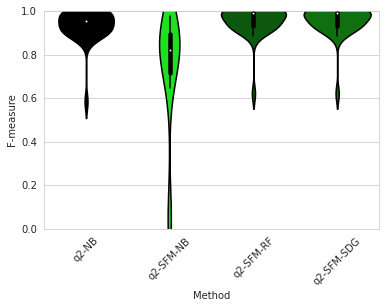

## gg_13_8_otus level 5

,Method,Parameters,Taxon Accuracy Rate,Taxon Detection Rate,Precision,Recall,F-measure
2,q2-SFM-RF,"0.001:0.7:[8, 8]:RandomForestClassifier(n_estimators=10):feature_importances_:8000",0.608811,0.737849,0.914171,0.817102,0.855588
3,q2-SFM-SDG,"0.001:0.7:[8, 8]:SGDClassifier(loss='modified_huber'):coef_:4000",0.617941,0.752742,0.897673,0.822380,0.854011
0,q2-NB,"0.01:0.7:[8, 8]",0.589262,0.701995,0.846124,0.781390,0.809425
1,q2-SFM-NB,"0.001:0.7:[8, 8]:MultinomialNB(alpha=0.1):feature_log_prob_:8000",0.580765,0.546890,0.893498,0.618424,0.696839


stat             P     FDR P
Method A   Method B                                    
q2-NB      q2-SFM-RF  -5.430730  5.672659e-06  0.000011
           q2-SFM-SDG -4.731601  4.328425e-05  0.000065
           q2-SFM-NB   4.091507  2.706419e-04  0.000325
q2-SFM-RF  q2-SFM-SDG  0.596560  5.549987e-01  0.554999
           q2-SFM-NB   6.024144  1.012192e-06  0.000003
q2-SFM-SDG q2-SFM-NB   6.272256  4.946638e-07  0.000003

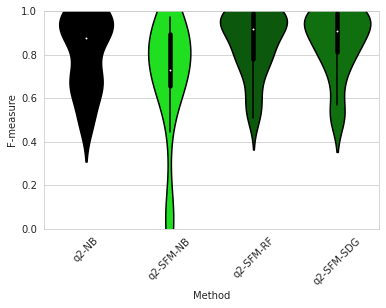

## gg_13_8_otus level 6

,Method,Parameters,Taxon Accuracy Rate,Taxon Detection Rate,Precision,Recall,F-measure
3,q2-SFM-SDG,"0.001:0.7:[8, 8]:SGDClassifier(loss='modified_huber'):coef_:4000",0.257243,0.287113,0.416197,0.229898,0.287995
2,q2-SFM-RF,"0.001:0.7:[8, 8]:RandomForestClassifier(n_estimators=10):feature_importances_:8000",0.243351,0.273377,0.438384,0.212739,0.275801
0,q2-NB,"0.01:0.7:[8, 8]",0.228958,0.252615,0.369943,0.232531,0.274125
1,q2-SFM-NB,"0.001:0.7:[8, 8]:MultinomialNB(alpha=0.1):feature_log_prob_:8000",0.240252,0.183838,0.413327,0.137054,0.186866


stat             P         FDR P
Method A   Method B                                        
q2-NB      q2-SFM-RF  -0.195252  8.464303e-01  8.464303e-01
           q2-SFM-SDG -1.575987  1.248649e-01  1.498379e-01
           q2-SFM-NB   5.639459  3.090176e-06  6.180353e-06
q2-SFM-RF  q2-SFM-SDG -1.869933  7.066588e-02  1.059988e-01
           q2-SFM-NB   5.755973  2.202492e-06  6.180353e-06
q2-SFM-SDG q2-SFM-NB   6.731540  1.329445e-07  7.976669e-07

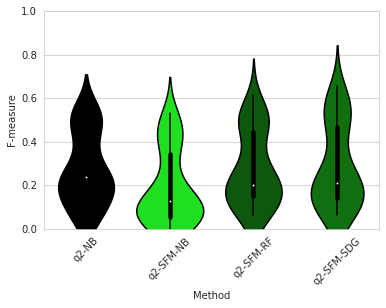

In [16]:
boxes = rank_optimized_method_performance_by_dataset(mock_results,
                                                     dataset="Reference",
                                                     metric="F-measure",
                                                     level_range=range(4,7),
                                                     display_fields=["Method",
                                                                     "Parameters",
                                                                     "Taxon Accuracy Rate",
                                                                     "Taxon Detection Rate",
                                                                     "Precision",
                                                                     "Recall",
                                                                     "F-measure"],
                                                     paired=True,
                                                     parametric=True,
                                                     color=None,
                                                     color_palette=color_palette)